<h1 style="background-color:rgb(67, 77, 86);
           font-size:300%;
           font-style: oblique;
           color:white;
           text-align:center;
           margin: auto;
           padding: 20px;">Predicting Bank Churners</h1>

<a id="1.2"></a>
<h2 style="background-color:rgb(141, 153, 165);
           font-size:250%;
           color:white;
           text-align:center;
           margin: auto;
           padding: 10px;">Table of Content</h2>

* ***[Introduction](#1)***
    * ***[Libraries & Modules](#1.1)***
    * ***[Data Loading](#1.2)***
* ***[Exploratory Data Analysis (EDA)](#2)***
* ***[Data Preprocessing](#3)***
    * ***[Data Upsampling Using SMOTE](#3.1)***
    * ***[Principal Component Analysis Of One Hot Encoded Data](#3.2)***  
* ***[Model Selection And Evaluation](#4)*** 
    * ***[Cross Validation](#4.1)***
    * ***[Model Evaluation](#4.2)***
    * ***[Model Evaluation On Original Data (Before Upsampling)](#4.3)***
* ***[Results](#5)*** 

> *Our top priority in this business problem is to identify customers who are getting churned. Even if we predict non-churning customers as churned, it won't harm our business. But predicting churning customers as Non-churning will do. So recall need to be higher. Till now, I have managed to get a recall of 62%. Need better. - Sakshi Goyal -*

<a id="1.2"></a>
<h2 style="background-color:rgb(141, 153, 165);
           font-size:250%;
           color:white;
           text-align:center;
           margin: auto;
           padding: 10px;">Libraries & Modules</h2>

In [1]:
# Data Processing
import pandas as pd
import numpy as np
import random as rd
import copy

# Explanatory Data Analysis
from pandas_profiling import ProfileReport

# Data Visualization
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import chart_studio.plotly
# import plotly.io as pio
# import seaborn as sns

# Statistical Analysis
from scipy.stats import (pearsonr, spearmanr, chi2_contingency)
# import scipy
# from scipy import stats

# Machine Learning
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score

In [2]:
# Settings
%matplotlib inline
pd.options.display.float_format = "{:,.2f}".format
# np.set_printoptions(precision=2)
# from IPython.display import display, Math, Latex
# pio.renderers.default='plotly_mimetype'
# plt.rc('figure',figsize=(8,4))
# plt.style.use('seaborn-whitegrid')

In [3]:
import os
for dirname, _, filenames in os.walk("Source"):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# Any results you write to the current directory are saved as output.

Source\BankChurners.csv
Source\d_minproc.csv
Source\img\Depiction-of-a-Precision-Recall-Curve.png
Source\img\Depiction-of-a-ROC-Curve.jpg
Source\img\How-to-Choose-a-Metric-for-Imbalanced-Classification-latest.png
Source\img\How-to-Spot-Check-Imbalanced-Machine-Learning-Algorithms.png
Source\img\How-to-Spot-Check-Machine-Learning-Algorithms.png
Source\img\QQPlot-Distributions.png
Source\img\QQPlot-Distributions2.png


<a id="1.2"></a>
<h2 style="background-color:rgb(141, 153, 165);
           font-size:250%;
           color:white;
           text-align:center;
           margin: auto;
           padding: 10px;">Data Loading</h2>

In [4]:
# Load Data
d = pd.read_csv('Source/BankChurners.csv')
d = d.iloc[:,:-2]  # deleting last two cols as instructed
d = d.drop(["CLIENTNUM"],axis=1) # drop var not needed

In [5]:
# Rename Columns
d.columns = ['churn', 'age', 'gender', 'dependents',
             'educ_cat', 'marstat', 'inc_cat', 'card_cat',
             'mo_on_book', 'prod_ct', 'mo_inactive_r12',
             'contr_ct_r12', 'credlim_avg_r12', 'revbal_avg_r12',
             'opentobuy_avg_r12', 'chng_tx_amt_q4_q1', 'tx_amt_r12',
             'tx_ct_r12', 'chng_tx_ct_q4_q1', 'utilratio_avg']

In [6]:
# Reorder Columns
d = d[['churn', 'age', 'gender', 'educ_cat', 'inc_cat', 'marstat', 'dependents',
       'card_cat', 'prod_ct', 'mo_on_book', 'mo_inactive_r12', 'contr_ct_r12', 
       'revbal_avg_r12', 'credlim_avg_r12', 'opentobuy_avg_r12', 'utilratio_avg',
       'tx_amt_r12', 'tx_ct_r12', 'chng_tx_amt_q4_q1', 'chng_tx_ct_q4_q1']]

In [7]:
# Reformat Text to Fix Weird Latex Problem
d['inc_cat'] = d['inc_cat'].replace({'$40K - $60K': '$40K-60K',
                                     '$60K - $80K': '$60K-80K',
                                     '$80K - $120K': '$80K-120K',
                                     '$120K +':'$120K+'})

In [8]:
d.head(3)

,churn,age,gender,educ_cat,inc_cat,marstat,dependents,card_cat,prod_ct,mo_on_book,mo_inactive_r12,contr_ct_r12,revbal_avg_r12,credlim_avg_r12,opentobuy_avg_r12,utilratio_avg,tx_amt_r12,tx_ct_r12,chng_tx_amt_q4_q1,chng_tx_ct_q4_q1
0,Existing Customer,45,M,High School,$60K-80K,Married,3,Blue,5,39,1,3,777,"12,691.00","11,914.00",0.06,1144,42,1.33,1.62
1,Existing Customer,49,F,Graduate,Less than $40K,Single,5,Blue,6,44,1,2,864,"8,256.00","7,392.00",0.10,1291,33,1.54,3.71
2,Existing Customer,51,M,Graduate,$80K-120K,Married,3,Blue,4,36,1,0,0,"3,418.00","3,418.00",0.00,1887,20,2.59,2.33


In [9]:
d_orig = copy.deepcopy(d)  # save original copy just in case

<a id="1.2"></a>
<h2 style="background-color:rgb(141, 153, 165);
           font-size:250%;
           color:white;
           text-align:center;
           margin: auto;
           padding: 10px;">Explanatory Data Analysis</h2>

In [ ]:
credit_card_report = ProfileReport(d)
credit_card_report

<a id="1.2"></a>
<h2 style="background-color:rgb(141, 153, 165);
           font-size:250%;
           color:white;
           text-align:center;
           margin: auto;
           padding: 10px;">Data Visualization</h2>

# Distribution of Numerical Variables

First it is important to note that the data is highly imbalanced as with most churn prediction problems. Only 16% of customers have churned (minority class), and the rest 84% are active customers (majority class). For this reason, we will approach this problem as an imbalanced classification task.

In [ ]:
px.pie(data_frame=d, names='churn', 
       title='Proportion of Attrited to Existing Customers', 
       color_discrete_sequence=["rgb(68, 130, 155)","rgb(64, 60, 115)"],
#        color_discrete_map={"Existing Customer":"rgb(68, 130, 155)",
#                            "Attrited Customer":"rgb(64, 60, 115)"},
       labels={'churn':'Customer Type'},
       opacity=.8, hole=0.33, width=700, height=700*(5/8))

In [ ]:
# Make a visualization variable of interest
d['tx_amt_pertx_r12'] = d['tx_amt_r12']/d['tx_ct_r12']

In [ ]:
def plot_distr_num(var_num, display_name, barmode='overlay'):
    fig = px.histogram(d, x=d[var_num], color='churn', marginal='box',
                       title=f'Distribution of {display_name} by Churn Status',
                       width=800,
                       height=500,
                       labels={var_num: display_name,  
                               'churn': 'Customer Type'},
                       opacity=0.5,
                       color_discrete_map={
                           'Attrited Customer':'rgb(64, 60, 115)',
                           'Existing Customer':'rgb(68, 130, 155)'},
                       category_orders={
                           'Churn':['Attrited Customer','Existing Customer']},
                       hover_data=d[['age', 'gender', 'educ_cat', 'inc_cat']])
    fig.update_layout(legend=dict(orientation="h",
                                  yanchor="bottom", y=1,
                                  xanchor="right", x=0.99),
                      barmode=barmode,
                      title_text=f'Distribution of {display_name} by Churn Status')
    fig.show()

In [ ]:
plot_distr_num('age', 'Age')

In [ ]:
plot_distr_num('dependents', 'Number of Dependents')

In [ ]:
plot_distr_num('prod_ct', 'Number of Products')

In [ ]:
plot_distr_num('mo_on_book', 'Months on Book')

The positive excess kurtosis of 0.4 represents a leptokurtic distribution where the distribution is more peaked compared to a gaussian distribution. The peak results from data points that are clustered along the x-axis. The tails are also heavier compared to those of a gaussian distribution. The coefficient of kurtosis is usally greater than 3, meaning that the excess kurtosis agaist the kurtosis of a normal distribution at 3 is positive.

A leptokurtic distribution means that small changes are less frequent since most of the data points are clustered around the mean. However, there are also large fluctuations in the both extremes, which can be seen by the heavy tails. 

In [ ]:
print('Kurtosis of months on book is %.3f.' %d['mo_on_book'].kurt())

In [ ]:
plot_distr_num('mo_inactive_r12', 'Months Inactive, R12')

In [ ]:
plot_distr_num('contr_ct_r12', 'Number of Contracts, R12')

In [ ]:
plot_distr_num('revbal_avg_r12', 'Revolving Balance, R12 Avg')

In [ ]:
plot_distr_num('credlim_avg_r12', 'Credit Limit, R12 Avg')

In [ ]:
plot_distr_num('utilratio_avg', 'Utilization Ratio, R12 Avg')

In [ ]:
plot_distr_num('tx_amt_r12', 'Transaction Amt, R12 Avg')

In [ ]:
plot_distr_num('tx_amt_pertx_r12', 'Avg Amt per Transaction')

In [ ]:
plot_distr_num('chng_tx_amt_q4_q1', 'Change in Transaction Amt, QoQ')

# Distribution of Categorical Variables

In [ ]:
def plot_distr_cat(var_cat, var_cat_display_name):
    
    palette_orig = px.colors.sequential.deep[::-1]
    palette_new = [palette_orig[0],palette_orig[2],palette_orig[4],
                   palette_orig[5],palette_orig[6],palette_orig[8],palette_orig[9]]
    
    d_bar = d.groupby('churn')[var_cat].value_counts().reset_index(name='ct')
    churn_ct_tot = d_bar.groupby('churn')['ct'].transform('sum')
    d_bar['%'] = d_bar['ct']/churn_ct_tot*100
    d_bar['churn'] = d_bar['churn'].map({'Existing Customer': 'Existing',
                                         'Attrited Customer': 'Attrited'})
    churn1 = d_bar[d_bar['churn']=='Attrited']
    churn0 = d_bar[d_bar['churn']=='Existing']
    
    tr0 = go.Bar(x=churn0['%'],
                 y=churn0['churn'],
                 name='Existing',
                 showlegend=False,
                 orientation='h',
                 hovertext=churn0['ct'],
                 text=churn0[var_cat],
                 texttemplate = "%{text} %{x:.0f}% <br>(%{hovertext:,d})",
                 textfont=dict(size=12, color='white'),
                 textposition = "inside",
                 marker=dict(color=palette_new, line=dict(color='rgb(248, 248, 249)', width=0.5)))
    tr1 = go.Bar(x=churn1['%'],
                 y=churn1['churn'],
                 name='Attrited',
                 showlegend=False,
                 orientation='h',
                 hovertext=churn1['ct'],
                 text=churn1[var_cat],
                 texttemplate = "%{text} %{x:.0f}% <br>(%{hovertext:,d})",
                 textfont=dict(size=12, color='white'),
                 textposition = "inside",
                 marker=dict(color=palette_new, line=dict(color='rgb(248, 248, 249)', width=0.5)))

    data = [tr0, tr1]
    layout = go.Layout(barmode = 'stack',
                       title=f'<b>Distribution of {var_cat_display_name} by Churn Status<b>',
                       xaxis=dict(title=f'{var_cat_display_name} (%)',
                                  titlefont_size=16,
#                                   categoryorder='array',
#                                   categoryarray=var_cat_display_order,
                                  tickmode='array',
                                  ticktext=['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'],
                                  tickfont_size=14,
                                  tickangle=0),
                       yaxis=dict(title='Customer Type',
                                  titlefont_size=16,
                                  tickfont_size=14,
                                  tickangle=-90),
                       margin=dict(l=120, r=10, t=140, b=80),
                       bargap=0.2,
                       bargroupgap=0.1,
                       width=1000,
                       height=500)
    
    fig = go.Figure(data=data, layout=layout)
    
    fig.show()

In [ ]:
plot_distr_cat('educ_cat', 'Education Level')

In [ ]:
plot_distr_cat('inc_cat', 'Income Level')

In [ ]:
plot_distr_cat('marstat', 'Marital Status')

In [ ]:
plot_distr_cat('dependents', 'Number of Dependents')

In [ ]:
plot_distr_cat('mo_inactive_r12', 'R12 Inactive Months')

In [ ]:
plot_distr_cat('prod_ct', 'Number of Products Held')

# Variance to Baseline

In [ ]:
def plot_var_to_baseline(var_cat, var_cat_display_name, var_cat_display_order):
    
    d_bar = d.groupby(var_cat)['churn'].value_counts().unstack(level=-1).reset_index().rename(
        columns={'Attrited Customer':'attrited', 
                 'Existing Customer':'existing'})
    d_bar['total'] = d_bar['attrited']+d_bar['existing']

    d_bar['%_attrited_class'] = d_bar['attrited']/sum(d_bar['attrited'])
    d_bar['%_existing_class'] = d_bar['existing']/sum(d_bar['existing'])
    d_bar['attrited_vs_existing'] = d_bar['%_attrited_class'] - d_bar['%_existing_class']

    tr = go.Bar(x=d_bar[var_cat],
                y=d_bar['attrited_vs_existing'],
                name='Attrited vs. Existing Customers',
                marker_color='rgba(64, 60, 115, 0.7)')

    data = [tr]
    
    layout = go.Layout(barmode = "stack",
                       title=f'Variance to Baseline of Attrited Customers by {var_cat_display_name}',
                       xaxis=dict(title=var_cat_display_name,
                                 titlefont_size=14,
                                 tickfont_size=12,
                                 tickangle=30,
                                 categoryorder='array',
                                 categoryarray=var_cat_display_order),
                       yaxis=dict(title='Variance to Baseline',
                                 titlefont_size=14,
                                 tickfont_size=12,
                                tickformat="%"),
                       bargap=0.2,
                       bargroupgap=0.1,
                       width=600,
                       height=400)
    fig = go.Figure(data=data, layout=layout)
    fig.show()

In [ ]:
order_cat = ['Unknown', 'Uneducated', 'High School', 
              'College', 'Graduate', 'Post-Graduate', 'Doctorate']
plot_var_to_baseline('educ_cat', 'Education Level', order_cat)

In [ ]:
order_cat = ['Unknown', 'Less than $40K', '$40K-60K', 
              '$60K-80K', '$80K-120K', '$120K+']
plot_var_to_baseline('inc_cat', 'Income Level', order_cat)

In [ ]:
order_cat = ['Unknown', 'Single', 'Married', 'Divorced']
plot_var_to_baseline('marstat', 'Marital Status', order_cat)

In [ ]:
order_cat = ['Blue', 'Silver', 'Gold', 'Platinum']
plot_var_to_baseline('card_cat', 'Card Type', order_cat)

# Probabilities

<a id="1.2"></a>
<h2 style="background-color:rgb(141, 153, 165);
           font-size:250%;
           color:white;
           text-align:center;
           margin: auto;
           padding: 10px;">Pre-Split Data Processing</h2>

We now conduct minimal data preprocessing that does not contribute to data leakage. Data leakage occurs when information from the test set leaks into the train set resulting in more optimistic performance metrics but less robust model against new data. To prevent data leakage, we will avoid using statistics such as mean and standard deviation etc. from the whole dataset to scale, impute, and feature engineer. Instead, we apply simple data type transformations and row-based feature engineering.

# Treatment of `Unknown`'s 

In this section, we examine the costs and benefits of dropping all the `nan`-equivalent classes `Unknown`'s identified in `educ_cat`, `inc_cat` and `marstat`. Below is the remaining sample if we were to drop all the `Unknown`'s in order to eliminate noise as much as possible.

In [10]:
def d_leftover(data, varlist):
    dic_leftover = {}
    for col in varlist:
        orig_data_ct = len(data)
        rem_data_ct = len(data.drop(data[col][data[col]=='Unknown'].index))
        perc_captured = round(rem_data_ct/orig_data_ct*100,0)
        dic_leftover[data[col].name] = [rem_data_ct, perc_captured]
        print(f"""Remaining sample when dropping `{data[col].name}`: {rem_data_ct} cases or {perc_captured}% of the original data \n""")
    rem_data_ct_if_all = len(d[d!='Unknown'].dropna())
    perc_captured_if_all = round(rem_data_ct_if_all/orig_data_ct*100,0)
    print(f"""Remaining sample when dropping all `unknowns`: {rem_data_ct_if_all} cases or {perc_captured_if_all}% of the original data \n""")

In [11]:
d_leftover(d, ["educ_cat","inc_cat","marstat"])

Remaining sample when dropping `educ_cat`: 8608 cases or 85.0% of the original data 

Remaining sample when dropping `inc_cat`: 9015 cases or 89.0% of the original data 

Remaining sample when dropping `marstat`: 9378 cases or 93.0% of the original data 

Remaining sample when dropping all `unknowns`: 7081 cases or 70.0% of the original data 



The loss of sample is 30% if we drop all of the `Unknown`'s. For this reason, we will not drop any of these "Unknown" cases. The "Unknown" cases for `educ_cat` will be assigned the same value as the `Uneducated` class, a value of `0`. Assumption is that most people who did not provide their education level might have been disinclined to do so due to their lower education status. Same assumption applies to `inc_cat`. We will transform `marstat` to dummies as `marstat` will be treated as non-ordinal.

# Data Types

In [12]:
# Types of data present in data
d.dtypes.unique()

array([dtype('O'), dtype('int64'), dtype('float64')], dtype=object)

In [13]:
# Current data type for each column
d.dtypes

churn                 object
age                    int64
gender                object
educ_cat              object
inc_cat               object
marstat               object
dependents             int64
card_cat              object
prod_ct                int64
mo_on_book             int64
mo_inactive_r12        int64
contr_ct_r12           int64
revbal_avg_r12         int64
credlim_avg_r12      float64
opentobuy_avg_r12    float64
utilratio_avg        float64
tx_amt_r12             int64
tx_ct_r12              int64
chng_tx_amt_q4_q1    float64
chng_tx_ct_q4_q1     float64
dtype: object

## Discrete Variable Classes

In [14]:
d_discrete = d.select_dtypes(['int64','object'])
for col in d_discrete:
    print(f"""{d_discrete[col].name}
    Data Type: {d_discrete[col].dtype}
    Unique Counts: {d_discrete[col].nunique()}
    Unique Values: {d_discrete[col].sort_values().unique()}\n""")

churn
    Data Type: object
    Unique Counts: 2
    Unique Values: ['Attrited Customer' 'Existing Customer']

age
    Data Type: int64
    Unique Counts: 45
    Unique Values: [26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 70 73]

gender
    Data Type: object
    Unique Counts: 2
    Unique Values: ['F' 'M']

educ_cat
    Data Type: object
    Unique Counts: 7
    Unique Values: ['College' 'Doctorate' 'Graduate' 'High School' 'Post-Graduate'
 'Uneducated' 'Unknown']

inc_cat
    Data Type: object
    Unique Counts: 6
    Unique Values: ['$120K+' '$40K-60K' '$60K-80K' '$80K-120K' 'Less than $40K' 'Unknown']

marstat
    Data Type: object
    Unique Counts: 4
    Unique Values: ['Divorced' 'Married' 'Single' 'Unknown']

dependents
    Data Type: int64
    Unique Counts: 6
    Unique Values: [0 1 2 3 4 5]

card_cat
    Data Type: object
    Unique Counts: 4
    Unique Values: ['Blue' 'Gold' 'Platinum' 'Si

## Continuous & Discrete Variables

In [15]:
# split continuous & discrete variables
d_discrete = d.select_dtypes(['int64','object'])
d_continuous = d.select_dtypes(['float64'])
print(f"""Discrete Variables: {list(d_discrete)}\n\nContinuous Variables: {list(d_continuous)}""")

Discrete Variables: ['churn', 'age', 'gender', 'educ_cat', 'inc_cat', 'marstat', 'dependents', 'card_cat', 'prod_ct', 'mo_on_book', 'mo_inactive_r12', 'contr_ct_r12', 'revbal_avg_r12', 'tx_amt_r12', 'tx_ct_r12']

Continuous Variables: ['credlim_avg_r12', 'opentobuy_avg_r12', 'utilratio_avg', 'chng_tx_amt_q4_q1', 'chng_tx_ct_q4_q1']


## Data Type Transformation

### Non-Ordinal - Integer to Float

* `revbal_avg_r12`
* `tx_amt_r12`

These variables are dollar amounts and are continuous up to tenths place. Therefore, we need to transform the data types to `float` from `int`.

In [16]:
d['revbal_avg_r12'] = d['revbal_avg_r12'].astype(float)
d['tx_amt_r12'] = d['tx_amt_r12'].astype(float)

### Non-Ordinal - String to Dummies

#### *Bi-Class*

* `churn`
* `gender`

In [17]:
d['churn'] = d['churn'].map({'Existing Customer': 0, 'Attrited Customer': 1})
d['gender'] = d['gender'].map({'M': 1, 'F': 0})

#### *Multi-Class*

* `marstat`
* `card_cat`

Even though `card_cat` can be regarded as ordinal, I decided to turn it into dummies as 93% of all customers have the Blue card out of the 4 possible card types.

In [39]:
print('Percentage of Blue card holders: %.3f' % (d_orig.groupby('card_cat').card_cat.count()[0]/len(d_orig)))

Percentage of Blue card holders: 0.932


In [18]:
d_dummies_marstat = pd.get_dummies(data=d['marstat'], prefix='marstat')
d_dummies_card = pd.get_dummies(data=d['card_cat'], prefix='card')

In [19]:
d = pd.concat([d, d_dummies_marstat, d_dummies_card], axis=1)
d.sample(3)

,churn,age,gender,educ_cat,inc_cat,marstat,dependents,card_cat,prod_ct,mo_on_book,...,chng_tx_amt_q4_q1,chng_tx_ct_q4_q1,marstat_Divorced,marstat_Married,marstat_Single,marstat_Unknown,card_Blue,card_Gold,card_Platinum,card_Silver
7124,0,51,0,Graduate,Less than $40K,Single,2,Blue,3,39,...,0.77,0.72,0,0,1,0,1,0,0,0
5168,1,30,0,Uneducated,Less than $40K,Divorced,1,Blue,6,19,...,0.82,0.52,1,0,0,0,1,0,0,0
9647,0,52,1,Unknown,$60K-80K,Single,5,Blue,2,36,...,0.75,0.85,0,0,1,0,1,0,0,0


### Ordinal - String to Ordinal

* `educ_cat`
* `inc_cat`

In [20]:
d['educ'] = d['educ_cat'].map({'Unknown':0,
                               'Uneducated':0,
                               'High School':1,
                               'College':2,
                               'Graduate':3,
                               'Post-Graduate':4,
                               'Doctorate':5})

d['inc'] = d['inc_cat'].map({'Unknown':0,
                             'Less than $40K':1,
                             '$40K-60K':2,
                             '$60K-80K':3,
                             '$80K-120K':4,
                             '$120K+':5})

### Feature Engineering without Data Leakage

In [21]:
# add a variable just to explore
d['tx_amt_pertx_r12'] = d['tx_amt_r12']/d['tx_ct_r12']

In [22]:
# save full dataset
d_full = copy.deepcopy(d)

In [23]:
# drop unnecessary variables for the data to fit 
d = d.drop(d[['educ_cat', 'inc_cat', 'marstat', 'card_cat']], axis=1)

In [24]:
# inspect new data
rd.seed(1)
d.sample(3)

,churn,age,gender,dependents,prod_ct,mo_on_book,mo_inactive_r12,contr_ct_r12,revbal_avg_r12,credlim_avg_r12,...,marstat_Married,marstat_Single,marstat_Unknown,card_Blue,card_Gold,card_Platinum,card_Silver,educ,inc,tx_amt_pertx_r12
7513,0,46,0,2,5,31,2,3,927.00,"8,243.00",...,0,1,0,1,0,0,0,3,0,50.03
4170,0,54,1,2,5,34,1,4,"1,471.00","6,401.00",...,1,0,0,1,0,0,0,0,3,70.87
7889,0,55,0,1,2,47,3,1,"1,780.00","2,343.00",...,0,1,0,1,0,0,0,1,2,66.24


In [25]:
# inspect new data types
d.dtypes

churn                  int64
age                    int64
gender                 int64
dependents             int64
prod_ct                int64
mo_on_book             int64
mo_inactive_r12        int64
contr_ct_r12           int64
revbal_avg_r12       float64
credlim_avg_r12      float64
opentobuy_avg_r12    float64
utilratio_avg        float64
tx_amt_r12           float64
tx_ct_r12              int64
chng_tx_amt_q4_q1    float64
chng_tx_ct_q4_q1     float64
marstat_Divorced       uint8
marstat_Married        uint8
marstat_Single         uint8
marstat_Unknown        uint8
card_Blue              uint8
card_Gold              uint8
card_Platinum          uint8
card_Silver            uint8
educ                   int64
inc                    int64
tx_amt_pertx_r12     float64
dtype: object

# Simple Visualization

<Figure size 432x288 with 0 Axes>

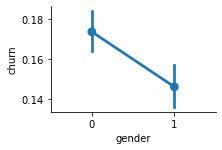

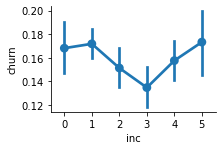

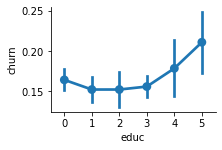

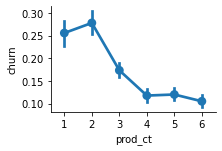

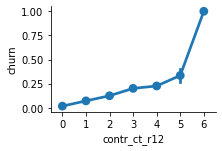

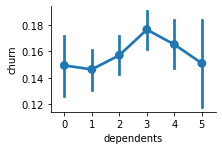

In [26]:
import seaborn as sns
import math
var_list = ['gender', 'inc', 'educ', 'prod_ct', 'contr_ct_r12', 'dependents']
for i, col in enumerate(var_list):
    plt.figure(i)
    sns.catplot(x=col, y='churn', data=d, 
                kind='point', aspect=1.5, height=2)

In [27]:
for i in var_list:
    print(d.groupby(i).churn.mean(),'\n')

gender
0   0.17
1   0.15
Name: churn, dtype: float64 

inc
0   0.17
1   0.17
2   0.15
3   0.13
4   0.16
5   0.17
Name: churn, dtype: float64 

educ
0   0.16
1   0.15
2   0.15
3   0.16
4   0.18
5   0.21
Name: churn, dtype: float64 

prod_ct
1   0.26
2   0.28
3   0.17
4   0.12
5   0.12
6   0.11
Name: churn, dtype: float64 

contr_ct_r12
0   0.02
1   0.07
2   0.12
3   0.20
4   0.23
5   0.34
6   1.00
Name: churn, dtype: float64 

dependents
0   0.15
1   0.15
2   0.16
3   0.18
4   0.17
5   0.15
Name: churn, dtype: float64 



<a id="1.2"></a>
<h2 style="background-color:rgb(141, 153, 165);
           font-size:250%;
           color:white;
           text-align:center;
           margin: auto;
           padding: 10px;">Normality Test</h2>

Let's take a look at some of the more promising candidates for normality from the data visualization section.

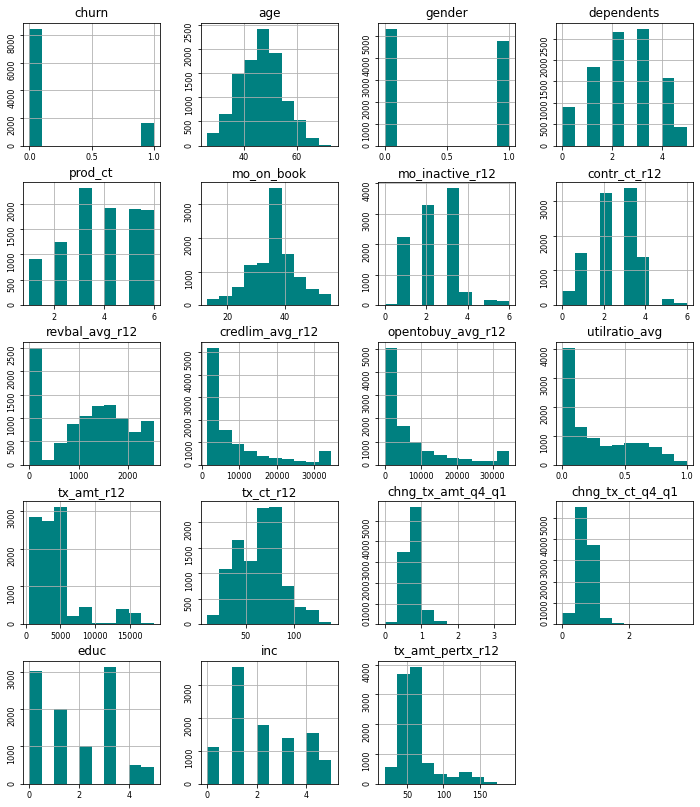

In [41]:
# histograms of the numerical variables
d_num = d.select_dtypes(['int64','float64'])
plt.rc('figure',figsize=(12,14))
d_num.hist(xlabelsize=8,ylabelsize=8,yrot=90,color='teal')
plt.show()

In [40]:
d.card_Blue.unique()

array([1, 0], dtype=uint8)

### QQ Plot

The Quantile-Quantile Plot known as the "QQ Plot" provides a visual representation of normality by comparing theoretical quantiles and the actual quantiles of our variable. The distance between the scatter plot and the red diagonal line represents deviation from a normal distribution. The QQ plot does a much better job in visualizing normality of a variable compared to Histogram or Box Plot.

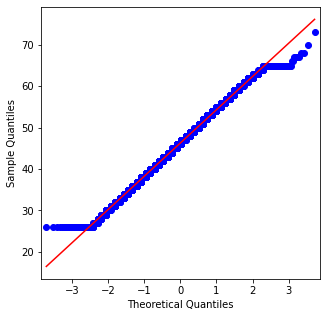

In [44]:
import statsmodels.api as sm
from scipy.stats import norm
import pylab
plt.rc('figure',figsize=(5,5))
my_data = d.age
sm.qqplot(my_data, line='s')
pylab.show()

## Statistical Tests

The Shapiro Wilk test is the most powerful test when testing for a normal distribution, but it typically becomes unreliable with a large sample size greater than a few thousand.

The D'Agostino's K Square test calculates summary statistics from the data, namely kurtosis and skewness, to determine if the data distribution departs from the normal distribution, named for Ralph D’Agostino.

### D'Agostino's K Square

In [45]:
from scipy.stats import normaltest
stat, p = normaltest(d['age'])
print('%s \nStatistics=%.3f, p=%.3f' % ('age', stat, p))
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0) \n')
else:
    print('Sample does not look Gaussian (reject H0) \n')

age 
Statistics=50.083, p=0.000
Sample does not look Gaussian (reject H0) 



### Anderson Test

In [46]:
from scipy.stats import anderson
result = anderson(d['age'])
print(' \n%s \nStatistics=%.3f' % ('age', round(result.statistic,3)))

for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

 
age 
Statistics=7.605
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)


### Jarque–Bera Test

In [47]:
from scipy.stats import jarque_bera
my_data = d.age.sample(2100)
stat, p = jarque_bera(my_data)
print('%s \nStatistics=%.3f, p=%.3f' % ('age', stat, p))
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0) \n')
else:
    print('Sample does not look Gaussian (reject H0) \n')

age 
Statistics=5.975, p=0.050
Sample looks Gaussian (fail to reject H0) 



<a id="1.2"></a>
<h2 style="background-color:rgb(141, 153, 165);
           font-size:250%;
           color:white;
           text-align:center;
           margin: auto;
           padding: 10px;">Scaling Data</h2>

# Min Max Scaler

In [ ]:
# demonstrate data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler
# load data
data = ...
# create scaler
scaler = MinMaxScaler()
# fit scaler on data
scaler.fit(data)
# apply transform
normalized = scaler.transform(data)
# inverse transform
inverse = scaler.inverse_transform(normalized)

# Min Max Scaler

<a id="1.2"></a>
<h2 style="background-color:rgb(141, 153, 165);
           font-size:250%;
           color:white;
           text-align:center;
           margin: auto;
           padding: 10px;">Feature Importance</h2>

# Decision Tree Classifier

In [48]:
X = d.iloc[:,1:]
y = d.iloc[:,:1]

In [49]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1, stratify=y)

In [50]:
for db in [x_train, x_test, y_train, y_test]:
    print(db.shape)

(8101, 26)
(2026, 26)
(8101, 1)
(2026, 1)


In [ ]:
from collections import Counter

In [52]:
Counter(y_test.churn)[1]/Counter(y_test.churn)[0]

0.19106407995296884

In [53]:
Counter(y_train.churn)[1]/Counter(y_train.churn)[0]

0.19149874981614942

In [57]:
X = x_train

In [58]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(x_train, y_train)

DecisionTreeClassifier()

In [59]:
importance = pd.DataFrame({'Feature': x_train.columns,
                           'Importance': np.round(model.feature_importances_,3)})
importance.sort_values('Importance', ascending=False, inplace=True)
importance.reset_index(drop=True)

,Feature,Importance
0,tx_ct_r12,0.27
1,revbal_avg_r12,0.18
2,tx_amt_r12,0.13
3,prod_ct,0.08
4,chng_tx_amt_q4_q1,0.07
5,chng_tx_ct_q4_q1,0.07
6,tx_amt_pertx_r12,0.06
7,age,0.03
8,contr_ct_r12,0.02
9,opentobuy_avg_r12,0.02


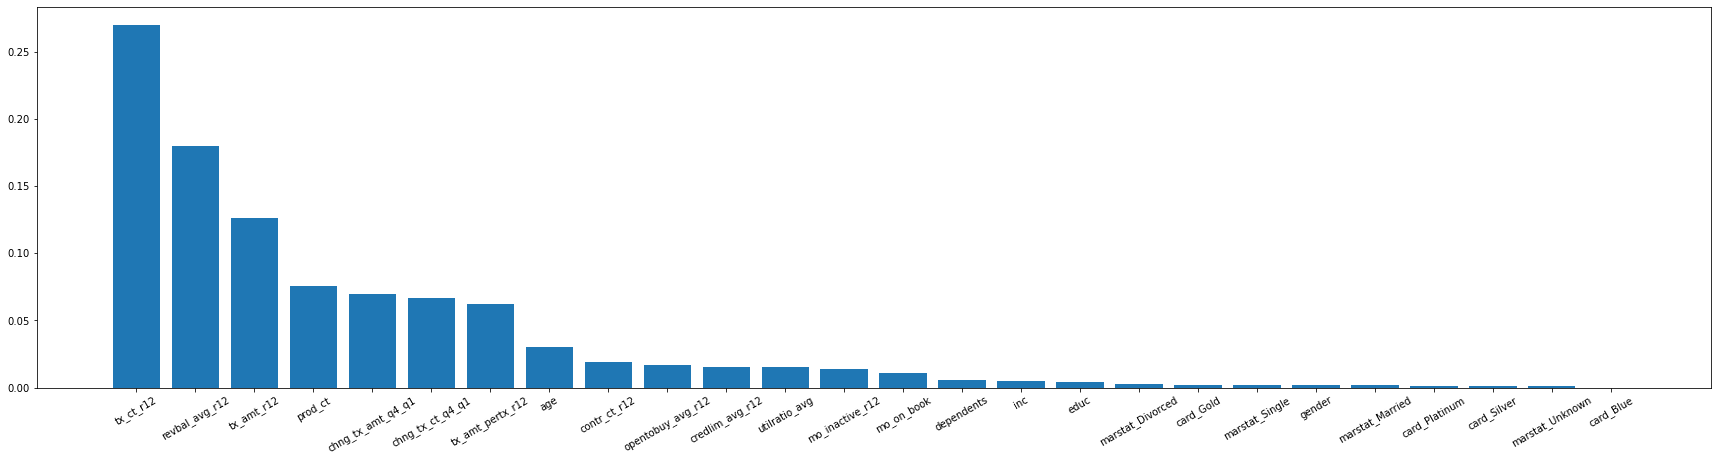

In [60]:
fig = plt.figure(figsize=(30,7))
plt.bar(importance.Feature, importance.Importance)
# plt.xticks(np.arange(26), x_train.columns, rotation=30)
plt.xticks(rotation=30)
plt.show()

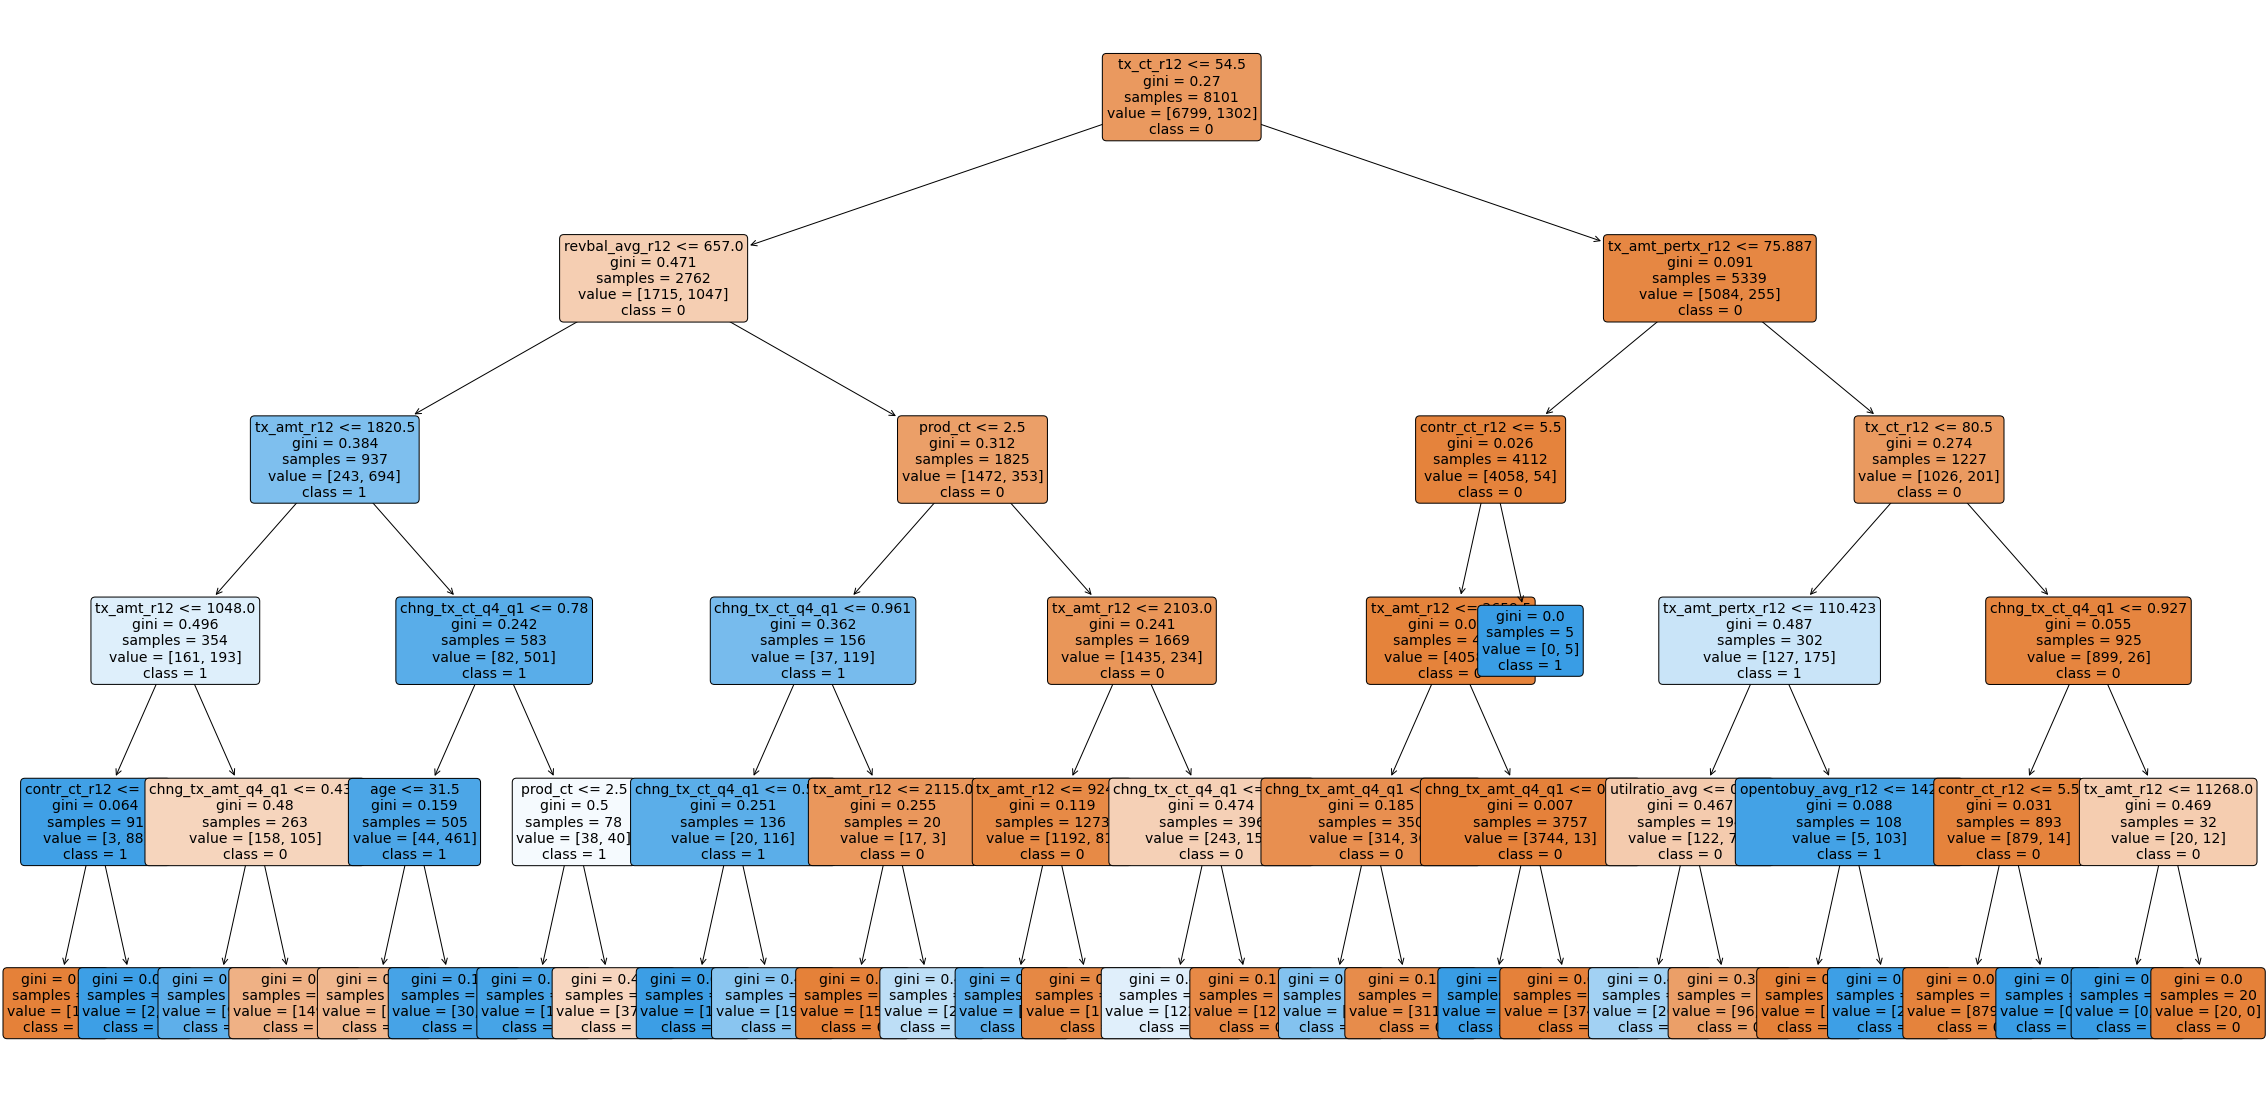

In [62]:
from sklearn import tree
model = DecisionTreeClassifier(max_depth=5, random_state=1)
model.fit(x_train, y_train)

plt.figure(figsize=(40,20))

# create the tree plot
a = tree.plot_tree(model,
                   # use the feature names stored
                   feature_names = x_train.columns,
                   # use the class names stored
                   class_names = y_train.churn.astype('str').unique(),
                   rounded = True,
                   filled = True,
                   fontsize=14)
# show the plot
plt.show()

In [ ]:
# # import relevant functions
# from sklearn.tree import export_text
# # export the decision rules
# tree_rules = export_text(model,
#                          feature_names = list(x_train.columns))
# # print the result
# print(tree_rules)

# Random Forest Classifier

In [66]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(x_train, y_train.churn.values)
rfc = pd.DataFrame({'Feature':x_train.columns,
                    'Importance': np.round(model.feature_importances_,3)})

RandomForestClassifier()

In [72]:
pd.options.display.float_format = "{:,.3f}".format
rfc.sort_values('Importance', ascending=False).reset_index(drop=True)

,Feature,Importance
0,tx_ct_r12,0.170
1,tx_amt_r12,0.168
2,revbal_avg_r12,0.106
3,chng_tx_ct_q4_q1,0.093
4,tx_amt_pertx_r12,0.073
5,chng_tx_amt_q4_q1,0.063
6,utilratio_avg,0.062
7,prod_ct,0.060
8,age,0.029
9,opentobuy_avg_r12,0.028


# XGBoost

In [75]:
import xgboost

In [77]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(x_train, y_train.churn.values)
xgbc = pd.DataFrame({'Feature': x_train.columns,
                     'Importance': np.round(model.feature_importances_,3)})
xgbc.sort_values('Importance',ascending=False).reset_index(drop=True)
            

C:\Users\April Leclair\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:42:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Feature,Importance
0,tx_ct_r12,0.235
1,revbal_avg_r12,0.171
2,prod_ct,0.097
3,tx_amt_r12,0.055
4,tx_amt_pertx_r12,0.049
5,chng_tx_ct_q4_q1,0.043
6,mo_inactive_r12,0.037
7,age,0.030
8,chng_tx_amt_q4_q1,0.030
9,gender,0.029


# Permutation Importance

In [ ]:
# # permutation feature importance with knn for classification
# from sklearn.datasets import make_classification
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.inspection import permutation_importance
# from matplotlib import pyplot
# # define dataset
# X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# # define the model
# model = KNeighborsClassifier()
# # fit the model
# model.fit(X, y)
# # perform permutation importance
# results = permutation_importance(model, X, y, scoring='accuracy')
# # get importance
# importance = results.importances_mean
# # summarize feature importance
# for i,v in enumerate(importance):
# 	print('Feature: %0d, Score: %.5f' % (i,v))
# # plot feature importance
# pyplot.bar([x for x in range(len(importance))], importance)
# pyplot.show()

In [ ]:
from sklearn.inspection import permutation_importance
# model = XGBClassifier()
# model.fit(x_train, y_train.churn.values)
# xgbc = pd.DataFrame({'Feature': x_train.columns,
#                      'Importance': np.round(model.feature_importances_,3)})
# xgbc.sort_values('Importance',ascending=False).reset_index(drop=True)
            

https://machinelearningmastery.com/calculate-feature-importance-with-python/

## Recursive Feature Elimination, or RFE

Recursive Feature Elimination, or RFE for short, is a popular feature selection algorithm.

In [80]:
from sklearn.feature_selection import RFE
rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=5)
rfe.fit(x_train, y_train.churn.values)

RFE(estimator=RandomForestClassifier(), n_features_to_select=5)

In [ ]:
# dir(rfe)

In [89]:
rfe_df = pd.DataFrame({'Feature': x_train.columns,
                     'Rank': np.round(rfe.ranking_,3)})
rfe_df.sort_values('Rank',ascending=True).reset_index(drop=True)

,Feature,Rank
0,tx_ct_r12,1
1,chng_tx_ct_q4_q1,1
2,chng_tx_amt_q4_q1,1
3,tx_amt_r12,1
4,revbal_avg_r12,1
5,tx_amt_pertx_r12,2
6,prod_ct,3
7,utilratio_avg,4
8,age,5
9,credlim_avg_r12,6


<a id="1.2"></a>
<h2 style="background-color:rgb(141, 153, 165);
           font-size:250%;
           color:white;
           text-align:center;
           margin: auto;
           padding: 10px;">Correlation Test</h2>

https://machinelearningmastery.com/how-to-calculate-nonparametric-rank-correlation-in-python/

# Correlation Tests
1. Pearson’s Correlation Coefficient
2. Spearman’s Rank Correlation
3. Kendall’s Rank Correlation
4. Chi-Squared Test

Spearman’s Rank Correlation.
Kendall’s Rank Correlation.
Goodman and Kruskal’s Rank Correlation.
Somers’ Rank Correlation.

In [ ]:
from scipy.stats import (pearsonr, spearmanr, kendalltau, 
                         chi2_contingency, f_oneway)

### Spearman's Rank Correlation

This statistical method quantifies the degree to which ranked variables are associated by a monotonic function, meaning an increasing or decreasing relationship. As a statistical hypothesis test, the method assumes that the samples are uncorrelated (fail to reject H0).

The intuition for the Spearman’s rank correlation is that it calculates a Pearson’s correlation (e.g. a parametric measure of correlation) using the rank values instead of the real values. Where the Pearson’s correlation is the calculation of the covariance (or expected difference of observations from the mean) between the two variables normalized by the variance or spread of both variables.

https://machinelearningmastery.com/how-to-calculate-nonparametric-rank-correlation-in-python/

In [ ]:
reject_h0 = {}
failtoreject_h0 = {}
d_rank = d.rank()
for i in d_rank.columns:
    coef, p = spearmanr(d_rank[i], d_rank['churn'])
    if p >= 0.05:
        failtoreject_h0[i] = [round(coef,3), round(p,3)]
    else:
        reject_h0[i] = [round(coef,3), round(p,3)]

In [ ]:
print(f'The following variables are NOT correlated to `churn`. We fail to reject H0: \n')
pd.options.display.float_format = "{:,.3f}".format
f = pd.DataFrame(failtoreject_h0).T
f.columns = ['coef', 'p-val']
f.sort_values('coef', ascending=False)

In [ ]:
print(f'The following variables are likely correlated to `churn`. We can safely reject H0: \n')
pd.options.display.float_format = "{:,.3f}".format
f = pd.DataFrame(reject_h0).T
f.columns = ['coef', 'p-val']
f[1:].sort_values('coef', ascending=False)

### Kendall's Rank Correlation

In [ ]:
reject_h0 = {}
failtoreject_h0 = {}
d_rank = d.rank()
for i in d_rank.columns:
    coef, p = kendalltau(d_rank[i], d_rank['churn'])
    if p >= 0.05:
        failtoreject_h0[i] = [round(coef,3), round(p,3)]
    else:
        reject_h0[i] = [round(coef,3), round(p,3)]

In [ ]:
print(f'The following variables are NOT dependent on `churn`. We fail to reject H0: \n')
pd.options.display.float_format = "{:,.3f}".format
f = pd.DataFrame(failtoreject_h0).T
f.columns = ['coef', 'p-val']
f.sort_values('coef', ascending=False)

In [ ]:
print(f'The following variables are likely dependent on `churn`. We can safely reject H0: \n')
pd.options.display.float_format = "{:,.3f}".format
f = pd.DataFrame(reject_h0).T
f.columns = ['coef', 'p-val']
f[1:].sort_values('coef', ascending=False)

### Chi-Squared Test

In [ ]:
len(d_discrete.columns)

In [ ]:
d_discrete = d.select_dtypes(['int64','uint8'])
d_continuous = d.select_dtypes(['float64'])

In [ ]:
discrete_cols = [*discrete.columns][1:]
continuous_cols = [*continuous.columns]

In [ ]:
reject_h0 = {}
failtoreject_h0 = {}
d_discrete_rank = d_discrete.rank()
for i in d_discrete_rank.columns:
    table = pd.crosstab(d_discrete_rank[i], d_discrete_rank['churn'])
    stat, p, dof, expected = chi2_contingency(table)
    if p >= 0.05:
        failtoreject_h0[i] = [round(stat,3), round(p,3), dof]
    else:
        reject_h0[i] = [round(stat,3), round(p,3), dof]

In [ ]:
print(f'The following variables are NOT dependent on `churn`. We fail to reject H0: \n')
pd.options.display.float_format = "{:,.3f}".format
f = pd.DataFrame(failtoreject_h0).T
f.columns = ['stat', 'p-val', 'df']
f.sort_values('p-val', ascending=False)

In [ ]:
print(f'The following variables are likely dependent on `churn`. We can safely reject H0: \n')
pd.options.display.float_format = "{:,.3f}".format
f = pd.DataFrame(reject_h0).T
f.columns = ['stat', 'p-val', 'df']
f[1:].sort_values('p-val', ascending=False)

## Mann-Whitney U Test
Tests whether the distributions of two independent samples are equal or not.

### Assumptions
1. Observations in each sample are independent and identically distributed (iid).
1. Observations in each sample can be ranked.

### Interpretation
* H0: the distributions of both samples are equal.
* H1: the distributions of both samples are not equal.

https://machinelearningmastery.com/statistical-hypothesis-tests-in-python-cheat-sheet/

<a id="1.2"></a>
<h2 style="background-color:rgb(141, 153, 165);
           font-size:250%;
           color:white;
           text-align:center;
           margin: auto;
           padding: 10px;">Normality Test</h2>

Let's take a look at some of the more promising candidates for normality from the data visualization section.

In [ ]:
# histograms of the variables
plt.rc('figure',figsize=(12,14))
d.hist(xlabelsize=8,ylabelsize=8,yrot=90,color='teal')
plt.show()

### QQ Plot

The Quantile-Quantile Plot known as the "QQ Plot" provides a visual representation of normality by comparing theoretical quantiles and the actual quantiles of our variable. The distance between the scatter plot and the red diagonal line represents deviation from a normal distribution. The QQ plot does a much better job in visualizing normality of a variable compared to Histogram or Box Plot.

In [ ]:
import statsmodels.api as sm
from scipy.stats import norm
import pylab

my_data = d.age
sm.qqplot(my_data, line='s')
pylab.show()

## Statistical Tests

The Shapiro Wilk test is the most powerful test when testing for a normal distribution, but it typically becomes unreliable with a large sample size greater than a few thousand.

The D'Agostino's K Square test calculates summary statistics from the data, namely kurtosis and skewness, to determine if the data distribution departs from the normal distribution, named for Ralph D’Agostino.

### D'Agostino's K Square

In [ ]:
from scipy.stats import normaltest
stat, p = normaltest(d['age'])
print('%s \nStatistics=%.3f, p=%.3f' % ('age', stat, p))
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0) \n')
else:
    print('Sample does not look Gaussian (reject H0) \n')

### Anderson Test

In [ ]:
from scipy.stats import anderson
result = anderson(d['age'])
print(' \n%s \nStatistics=%.3f' % ('age', round(result.statistic,3)))

for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

### Jarque–Bera Test

In [ ]:
from scipy.stats import jarque_bera
my_data = d.age.sample(2100)
stat, p = jarque_bera(my_data)
print('%s \nStatistics=%.3f, p=%.3f' % ('age', stat, p))
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0) \n')
else:
    print('Sample does not look Gaussian (reject H0) \n')

<a id="1.2"></a>
<h2 style="background-color:rgb(141, 153, 165);
           font-size:250%;
           color:white;
           text-align:center;
           margin: auto;
           padding: 10px;">Train Test Split</h2>

In [ ]:
X = d.iloc[:,1:]
y = d.iloc[:,:1]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1, stratify=y)

In [ ]:
for db in [x_train, x_test, y_train, y_test]:
    print(db.shape)

In [ ]:
from collections import Counter

In [ ]:
counter = Counter(y_train.churn)
X = x_train

In [ ]:
Counter(y_test.churn)[1]/Counter(y_test.churn)[0]

In [ ]:
Counter(y_train.churn)[1]/Counter(y_train.churn)[0]

In [ ]:
# evaluate imbalanced classification model with different metrics
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [ ]:
# define model
model = LogisticRegression(solver='liblinear')
# fit model
model.fit(trainX, trainy)
# predict on test set
yhat = model.predict(testX)
# evaluate predictions
print('Accuracy: %.3f' % accuracy_score(testy, yhat))
print('Precision: %.3f' % precision_score(testy, yhat))
print('Recall: %.3f' % recall_score(testy, yhat))
print('F-measure: %.3f' % f1_score(testy, yhat))

<a id="1.2"></a>
<h2 style="background-color:rgb(141, 153, 165);
           font-size:250%;
           color:white;
           text-align:center;
           margin: auto;
           padding: 10px;">Post-Split Data Processing</h2>

Consistent with the EDA section, none of the variables seems to have a normal distribution. `age` looks closer to a normal distribution but still does not look quite normal. We must transform these variables to apply parametric methods, as most of the parametric methods require a normality assumption.

# Scaling

https://medium.com/@rrfd/standardize-or-normalize-examples-in-python-e3f174b65dfc

In [ ]:
# define the scaler
scaler = MinMaxScaler()
# fit on the training dataset
scaler.fit(X_train)
# scale the training dataset
X_train = scaler.transform(X_train)
# scale the test dataset
X_test = scaler.transform(X_test)

## Standard Scaler 

The Standard Scaler assumes **data is normally distributed** within each feature and scales them such that the distribution centered around 0, with a standard deviation of 1. Centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the training set. If data is not normally distributed, this is not the best Scaler to use. Therefore, we will not be using the Standard Scaler before normalizing the data.

[Source: All About Feature Scaling](https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35)

## Min-Max Scaler

Transform features by scaling each feature to a given range. This estimator scales and translates each feature individually such that it is in the given range on the training set, e.g., between zero and one. This Scaler shrinks the data within the range of -1 to 1 if there are negative values. We can set the range like [0,1] or [0,5] or [-1,1].

This Scaler responds well if **the standard deviation is small** and when a **distribution is not Gaussian**. This Scaler is **sensitive to outliers**.

[Source: All About Feature Scaling](https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35)

## Max Abs Scaler

Scale each feature by its **maximum absolute value**. This estimator scales and translates each feature individually such that the maximal absolute value of each feature in the training set is 1.0. It does not shift/center the data and thus does not destroy any **sparsity**.

On positive-only data, this Scaler behaves similarly to Min Max Scaler and, therefore, also **suffers from the presence of significant outliers**.

[Source: All About Feature Scaling](https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35)

## Robust Scaler

As the name suggests, this Scaler is **robust to outliers**. If our data contains many outliers, scaling using the mean and standard deviation of the data won’t work well.

This Scaler removes the median and scales the data according to the **quantile range** (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile). The centering and scaling statistics of this Scaler are based on percentiles and are therefore not influenced by a few numbers of huge marginal outliers. Note that the **outliers themselves are still present** in the transformed data. If a separate outlier clipping is desirable, a non-linear transformation is required.

[Source: All About Feature Scaling](https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35)

## Quantile Transformer Scaler

Transform features using **quantiles information**.

This method transforms the features to follow a **uniform or a normal distribution**. Therefore, for a given feature, this transformation tends to **spread out the most frequent values**. It also reduces the impact of (marginal) outliers: this is, therefore, a robust pre-processing scheme.
The cumulative distribution function of a feature is used to project the original values. Note that this transform is **non-linear** and may distort linear correlations between variables measured at the same scale but renders variables measured at different scales more directly comparable. This is also sometimes called as **Rank scaler**.

[Source: All About Feature Scaling](https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35)

## Power Transformer Scaler

The power transformer is a family of **parametric, monotonic** transformations that are applied to **make data more Gaussian-like**. This is useful for modeling issues related to the variability of a variable that is unequal across the range **(heteroscedasticity)** or situations where **normality is desired**.

The power transform finds the optimal scaling factor in **stabilizing variance and minimizing skewness through maximum likelihood estimation**. Currently, Sklearn implementation of PowerTransformer supports the Box-Cox transform and the Yeo-Johnson transform. The optimal parameter for stabilizing variance and minimizing skewness is estimated through maximum likelihood. Box-Cox requires input data to be strictly positive, while Yeo-Johnson supports both positive or negative data.

[Source: All About Feature Scaling](https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35)

## Unit Vector Scaler

Scaling is done considering the **whole feature vector to be of unit length**. This usually means dividing each component by the Euclidean length of the vector (**L2 Norm**). In some applications (e.g., histogram features), it can be more practical to use the L1 norm of the feature vector.

Like Min-Max Scaling, the Unit Vector technique produces **values of range [0,1]**. When dealing with **features with hard boundaries**, this is quite useful. For example, when dealing with image data, the colors can range from only 0 to 255.

[Source: All About Feature Scaling](https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35)

# Resampling

## ***SMOTE*** for Balancing Data

>... ***SMOTE*** first selects a minority class instance a at random and finds its $k$ nearest minority class neighbors. The synthetic instance is then created by choosing one of the $k$ nearest neighbors $b$ at random and connecting $a$ and $b$ to form a line segment in the feature space. The synthetic instances are generated as a convex combination of the two chosen instances $a$ and $b$.

[Source: — Page 47, Imbalanced Learning: Foundations, Algorithms, and Applications, 2013.](https://www.amazon.com/dp/1118074629)

[Source: Machine Learning Mastery](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)

We can use the `Counter` object to summarize the number of examples in each class to confirm the dataset was created correctly. A general downside of the approach is that synthetic examples are created without considering the majority class, possibly resulting in ambiguous examples if there is a strong overlap for the classes.

In [ ]:
# example of oversampling the minority class
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
# generate dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0, n_clusters_per_class=1, weights=[0.99, 0.01], flip_y=0)
# summarize class distribution
print(Counter(y))
# define oversample strategy
oversample = SMOTE(sampling_strategy=0.5)
# fit and apply the transform
X_over, y_over = oversample.fit_resample(X, y)
# summarize class distribution
print(Counter(y_over))

In [ ]:
# example of undersampling the majority class
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler
# generate dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0, n_clusters_per_class=1, weights=[0.99, 0.01], flip_y=0)
# summarize class distribution
print(Counter(y))
# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy=0.5)
# fit and apply the transform
X_under, y_under = undersample.fit_resample(X, y)
# summarize class distribution
print(Counter(y_under))

In [ ]:
# example of both undersampling and oversampling
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.combine import SMOTEENN
# generate dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0, n_clusters_per_class=1, weights=[0.99, 0.01], flip_y=0)
# summarize class distribution
print(Counter(y))
# define sampling strategy
sample = SMOTEENN(sampling_strategy=0.5)
# fit and apply the transform
X_over, y_over = sample.fit_resample(X, y)
# summarize class distribution
print(Counter(y_over))

In [ ]:
# oversample = SMOTE()
# X, y = oversample.fit_resample(c_data[c_data.columns[1:]], c_data[c_data.columns[0]])
# usampled_df = X.assign(Churn = y)

In [ ]:
# ohe_data =usampled_df[usampled_df.columns[15:-1]].copy()
# usampled_df = usampled_df.drop(columns=usampled_df.columns[15:-1])

In [ ]:
# fig = make_subplots(rows=2, cols=1,shared_xaxes=True,subplot_titles=('Perason Correaltion',  'Spearman Correaltion'))
# colorscale=     [[1.0              , "rgb(165,0,38)"],
#                 [0.8888888888888888, "rgb(215,48,39)"],
#                 [0.7777777777777778, "rgb(244,109,67)"],
#                 [0.6666666666666666, "rgb(253,174,97)"],
#                 [0.5555555555555556, "rgb(254,224,144)"],
#                 [0.4444444444444444, "rgb(224,243,248)"],
#                 [0.3333333333333333, "rgb(171,217,233)"],
#                 [0.2222222222222222, "rgb(116,173,209)"],
#                 [0.1111111111111111, "rgb(69,117,180)"],
#                 [0.0               , "rgb(49,54,149)"]]

# s_val =usampled_df.corr('pearson')
# s_idx = s_val.index
# s_col = s_val.columns
# s_val = s_val.values
# fig.add_trace(
#     go.Heatmap(x=s_col,y=s_idx,z=s_val,name='pearson',showscale=False,xgap=1,ygap=1,colorscale=colorscale),
#     row=1, col=1
# )


# s_val =usampled_df.corr('spearman')
# s_idx = s_val.index
# s_col = s_val.columns
# s_val = s_val.values
# fig.add_trace(
#     go.Heatmap(x=s_col,y=s_idx,z=s_val,xgap=1,ygap=1,colorscale=colorscale),
#     row=2, col=1
# )
# fig.update_layout(
#     hoverlabel=dict(
#         bgcolor="white",
#         font_size=16,
#         font_family="Rockwell"
#     )
# )
# fig.update_layout(height=700, width=900, title_text="Upsmapled Correlations")
# fig.show()

# Feature Selection

Three benefits of performing feature selection before modeling your data are:

* Reduces Overfitting: Less redundant data means less opportunity to make decisions based on noise.
* Improves Accuracy: Less misleading data means modeling accuracy improves.
* Reduces Training Time: Less data means that algorithms train faster.

https://machinelearningmastery.com/feature-selection-machine-learning-python/

Per Jason: "Use separate statistical feature selection methods for different variable types. Or try RFE." https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/

Kendall’s rank coefficient (nonlinear).
https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/

https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/

## Categorical Input, Categorical Output

The most common correlation measure for categorical data is the chi-squared test. You can also use mutual information (information gain) from the field of information theory. In fact, mutual information is a powerful method that may prove useful for both categorical and numerical data, e.g. it is agnostic to the data types.

https://machinelearningmastery.com/feature-selection-with-categorical-data/

### Chi Square

In [ ]:
# example of loading and preparing the breast cancer dataset
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

In [ ]:
# load the dataset
def load_dataset(filename):
	# load the dataset as a pandas DataFrame
	data = read_csv(filename, header=None)
	# retrieve numpy array
	dataset = data.values
	# split into input (X) and output (y) variables
	X = dataset[:, :-1]
	y = dataset[:,-1]
	# format all fields as string
	X = X.astype(str)
	return X, y

In [ ]:
# prepare input data
def prepare_inputs(X_train, X_test):
	oe = OrdinalEncoder()
	oe.fit(X_train)
	X_train_enc = oe.transform(X_train)
	X_test_enc = oe.transform(X_test)
	return X_train_enc, X_test_enc

In [ ]:
# prepare target
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	le.fit(y_train)
	y_train_enc = le.transform(y_train)
	y_test_enc = le.transform(y_test)
	return y_train_enc, y_test_enc

In [ ]:
# load the dataset
X, y = load_dataset('breast-cancer.csv')
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# prepare input data
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)
# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)

### Mutual Information

In [ ]:
# example of mutual information feature selection for categorical data
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from matplotlib import pyplot

In [ ]:
# load the dataset
def load_dataset(filename):
	# load the dataset as a pandas DataFrame
	data = read_csv(filename, header=None)
	# retrieve numpy array
	dataset = data.values
	# split into input (X) and output (y) variables
	X = dataset[:, :-1]
	y = dataset[:,-1]
	# format all fields as string
	X = X.astype(str)
	return X, y

In [ ]:
# prepare input data
def prepare_inputs(X_train, X_test):
	oe = OrdinalEncoder()
	oe.fit(X_train)
	X_train_enc = oe.transform(X_train)
	X_test_enc = oe.transform(X_test)
	return X_train_enc, X_test_enc

In [ ]:
# prepare target
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	le.fit(y_train)
	y_train_enc = le.transform(y_train)
	y_test_enc = le.transform(y_test)
	return y_train_enc, y_test_enc

In [ ]:
# feature selection
def select_features(X_train, y_train, X_test):
	fs = SelectKBest(score_func=mutual_info_classif, k='all')
	fs.fit(X_train, y_train)
	X_train_fs = fs.transform(X_train)
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

In [ ]:
# load the dataset
X, y = load_dataset('breast-cancer.csv')
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# prepare input data
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)
# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train_enc, y_train_enc, X_test_enc)
# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

## Numerical Input, Categorical Output

In [ ]:
def calc_r(method, var1, var2):
    """Calculates Pearson or Spearman R"""
    if method=="p":
        r_coeff, p_val = pearsonr(var1, var2)
        print(f'[{var1.name} & {var2.name}] \n  Pearson R Correlation Coefficient: {round(r_coeff,3)} \n  p-value: {round(p_val,3)}')
    else:
        r_coeff, p_val = spearmanr(var1, var2)
        print(f'[{var1.name} & {var2.name}] \n  Spearman R Correlation Coefficient: {round(r_coeff,3)} \n  p-value: {round(p_val,3)}')    
    return([r_coeff, p_val])

In [ ]:
calc_r('s', d['opentobuy_avg_r12'], d['credlim_avg_r12'])

In [ ]:
d['tx_amt_pertx_r12'] = d['tx_amt_r12']/d['tx_ct_r12']

In [ ]:
corr_columns_spearman = ['Churn', 'Age', 'Gender', 'Education', 'Income', 'Marital', 
                         'Dependents', 'Card Type', 'Product Ct', 'Mo on Book', 
                         'Mo Inactive, R12', 'Contract Ct, R12',
                         'Revolving Balance', 'Credit Limit', 'Open to Buy', 'Utilization Ratio',
                         'Tx Amt, R12', 'Tx Ct, R12',
                         'Change in Tx Amt, Q4-Q1', 'Change in Tx Ct, Q4-Q1','Tx Amt per Tx, R12']

In [ ]:
corr_columns = ['Age', 'Dependents', 'Product Ct', 'Mo on Book', 
                'Mo Inactive, R12', 'Contract Ct, R12', 
                'Revolving Balance', 'Credit Limit', 'Open to Buy', 'Utilization Ratio',
                'Tx Amt, R12', 'Tx Ct, R12', 
                'Change in Tx Amt, Q4-Q1', 'Change in Tx Ct, Q4-Q1','Tx Amt per Tx, R12']

## Spearman's

In [ ]:
fig = px.imshow(d.rank().corr(method='spearman'), 
                x=corr_columns_spearman, 
                y=corr_columns_spearman, 
                labels=dict(x="", y="", color="Correlation"),
                color_continuous_scale='GnBu',
                width=600, height=600)
fig.show()

## Pearson's

In [ ]:
fig = px.imshow(d.corr(), 
                x=corr_columns, 
                y=corr_columns, 
                labels=dict(x="", y="", color="Correlation"),
                color_continuous_scale='GnBu',
                width=600, height=600)
fig.show()

In [ ]:
# ANOVA feature selection for numeric input and categorical output
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
# generate dataset
X, y = make_classification(n_samples=100, n_features=20, n_informative=2)
# define feature selection
fs = SelectKBest(score_func=f_classif, k=2)
# apply feature selection
X_selected = fs.fit_transform(X, y)
print(X_selected.shape)

## RFE: Recursive Feature Elimination

https://machinelearningmastery.com/rfe-feature-selection-in-python/

### Wrapper-type (not filter-based) feature selection algorithm

RFE works by searching for a subset of features by starting with all features in the training dataset and successfully removing features until the desired number remains.

This is achieved by fitting the given machine learning algorithm used in the core of the model, ranking features by importance, discarding the least important features, and re-fitting the model. This process is repeated until a specified number of features remains.

Features are scored either using the provided machine learning model (e.g. some algorithms like decision trees offer importance scores) or by using a statistical method.

In [ ]:
# evaluate RFE for classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
# define dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# create pipeline
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)
model = DecisionTreeClassifier()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

In [ ]:
# make a prediction with an RFE pipeline
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
# define dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# create pipeline
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)
model = DecisionTreeClassifier()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# fit the model on all available data
pipeline.fit(X, y)
# make a prediction for one example
data = [[2.56999479,-0.13019997,3.16075093,-4.35936352,-1.61271951,-1.39352057,-2.48924933,-1.93094078,3.26130366,2.05692145]]
yhat = pipeline.predict(data)
print('Predicted Class: %d' % (yhat))

In [ ]:
# explore the number of selected features for RFE
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from matplotlib import pyplot

# get the dataset
def get_dataset():
	X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
	return X, y

# get a list of models to evaluate
def get_models():
	models = dict()
	for i in range(2, 10):
		rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=i)
		model = DecisionTreeClassifier()
		models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
	return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores

# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

## Explore Base Algorithm

In [ ]:
# explore the algorithm wrapped by RFE
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from matplotlib import pyplot

# get the dataset
def get_dataset():
	X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
	return X, y

# get a list of models to evaluate
def get_models():
	models = dict()
	# lr
	rfe = RFE(estimator=LogisticRegression(), n_features_to_select=5)
	model = DecisionTreeClassifier()
	models['lr'] = Pipeline(steps=[('s',rfe),('m',model)])
	# perceptron
	rfe = RFE(estimator=Perceptron(), n_features_to_select=5)
	model = DecisionTreeClassifier()
	models['per'] = Pipeline(steps=[('s',rfe),('m',model)])
	# cart
	rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)
	model = DecisionTreeClassifier()
	models['cart'] = Pipeline(steps=[('s',rfe),('m',model)])
	# rf
	rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=5)
	model = DecisionTreeClassifier()
	models['rf'] = Pipeline(steps=[('s',rfe),('m',model)])
	# gbm
	rfe = RFE(estimator=GradientBoostingClassifier(), n_features_to_select=5)
	model = DecisionTreeClassifier()
	models['gbm'] = Pipeline(steps=[('s',rfe),('m',model)])
	return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

### Select All Features - Naiive Approach to Beat

In [ ]:
# evaluation of a model using all input features
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# load the dataset
def load_dataset(filename):
	# load the dataset as a pandas DataFrame
	data = read_csv(filename, header=None)
	# retrieve numpy array
	dataset = data.values
	# split into input (X) and output (y) variables
	X = dataset[:, :-1]
	y = dataset[:,-1]
	# format all fields as string
	X = X.astype(str)
	return X, y

# prepare input data
def prepare_inputs(X_train, X_test):
	oe = OrdinalEncoder()
	oe.fit(X_train)
	X_train_enc = oe.transform(X_train)
	X_test_enc = oe.transform(X_test)
	return X_train_enc, X_test_enc

# prepare target
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	le.fit(y_train)
	y_train_enc = le.transform(y_train)
	y_test_enc = le.transform(y_test)
	return y_train_enc, y_test_enc

# load the dataset
X, y = load_dataset('breast-cancer.csv')
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# prepare input data
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)
# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)
# fit the model
model = LogisticRegression(solver='lbfgs')
model.fit(X_train_enc, y_train_enc)
# evaluate the model
yhat = model.predict(X_test_enc)
# evaluate predictions
accuracy = accuracy_score(y_test_enc, yhat)
print('Accuracy: %.2f' % (accuracy*100))

### Model Built Using Chi-Squared Features

In this case, we see that the model achieved an accuracy of about 74%, a slight drop in performance.

It is possible that some of the features removed are, in fact, adding value directly or in concert with the selected features.

At this stage, we would probably prefer to use all of the input features.

In [ ]:
# evaluation of a model fit using chi squared input features
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# load the dataset
def load_dataset(filename):
	# load the dataset as a pandas DataFrame
	data = read_csv(filename, header=None)
	# retrieve numpy array
	dataset = data.values
	# split into input (X) and output (y) variables
	X = dataset[:, :-1]
	y = dataset[:,-1]
	# format all fields as string
	X = X.astype(str)
	return X, y

# prepare input data
def prepare_inputs(X_train, X_test):
	oe = OrdinalEncoder()
	oe.fit(X_train)
	X_train_enc = oe.transform(X_train)
	X_test_enc = oe.transform(X_test)
	return X_train_enc, X_test_enc

# prepare target
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	le.fit(y_train)
	y_train_enc = le.transform(y_train)
	y_test_enc = le.transform(y_test)
	return y_train_enc, y_test_enc

# feature selection
def select_features(X_train, y_train, X_test):
	fs = SelectKBest(score_func=chi2, k=4)
	fs.fit(X_train, y_train)
	X_train_fs = fs.transform(X_train)
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs

# load the dataset
X, y = load_dataset('breast-cancer.csv')
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# prepare input data
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)
# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)
# feature selection
X_train_fs, X_test_fs = select_features(X_train_enc, y_train_enc, X_test_enc)
# fit the model
model = LogisticRegression(solver='lbfgs')
model.fit(X_train_fs, y_train_enc)
# evaluate the model
yhat = model.predict(X_test_fs)
# evaluate predictions
accuracy = accuracy_score(y_test_enc, yhat)
print('Accuracy: %.2f' % (accuracy*100))

### Model Built Using Mutual Information Features

In this case, we can see a small lift in classification accuracy to 76%.

To be sure that the effect is real, it would be a good idea to repeat each experiment multiple times and compare the mean performance. It may also be a good idea to explore using k-fold cross-validation instead of a simple train/test split.

In [ ]:
# evaluation of a model fit using mutual information input features
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# load the dataset
def load_dataset(filename):
	# load the dataset as a pandas DataFrame
	data = read_csv(filename, header=None)
	# retrieve numpy array
	dataset = data.values
	# split into input (X) and output (y) variables
	X = dataset[:, :-1]
	y = dataset[:,-1]
	# format all fields as string
	X = X.astype(str)
	return X, y

# prepare input data
def prepare_inputs(X_train, X_test):
	oe = OrdinalEncoder()
	oe.fit(X_train)
	X_train_enc = oe.transform(X_train)
	X_test_enc = oe.transform(X_test)
	return X_train_enc, X_test_enc

# prepare target
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	le.fit(y_train)
	y_train_enc = le.transform(y_train)
	y_test_enc = le.transform(y_test)
	return y_train_enc, y_test_enc

# feature selection
def select_features(X_train, y_train, X_test):
	fs = SelectKBest(score_func=mutual_info_classif, k=4)
	fs.fit(X_train, y_train)
	X_train_fs = fs.transform(X_train)
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs

# load the dataset
X, y = load_dataset('breast-cancer.csv')
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# prepare input data
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)
# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)
# feature selection
X_train_fs, X_test_fs = select_features(X_train_enc, y_train_enc, X_test_enc)
# fit the model
model = LogisticRegression(solver='lbfgs')
model.fit(X_train_fs, y_train_enc)
# evaluate the model
yhat = model.predict(X_test_fs)
# evaluate predictions
accuracy = accuracy_score(y_test_enc, yhat)
print('Accuracy: %.2f' % (accuracy*100))

<a id="1.2"></a>
<h2 style="background-color:rgb(141, 153, 165);
           font-size:250%;
           color:white;
           text-align:center;
           margin: auto;
           padding: 10px;">Model Selection & Evaluation</h2>

[Source: Machine Learning Mastery, Step-By-Step Framework for Imbalanced Classification Projects](https://machinelearningmastery.com/framework-for-imbalanced-classification-projects/)

# Metric Selection

## PRAUC

PRAUC stands for Precision-Recall Area Under Curve. Using this metric, we can predict probabilities with custom threshold to identify a crisp label. This method will optimize both precision and recall across all threshold values. This approach is similar to an AUC that maximizes true positives and minimizes false positives but is more appropriate for imbalanced classification as correctly predicting a positive class is more important.

In [ ]:
# evaluate imbalanced classification model with different metrics
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
# generate dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0, n_clusters_per_class=1, weights=[0.99], flip_y=0)
# split into train/test sets with same class ratio
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, stratify=y)
# define model
model = LogisticRegression(solver='liblinear')
# fit model
model.fit(trainX, trainy)
# predict on test set
yhat = model.predict(testX)
# evaluate predictions
print('Accuracy: %.3f' % accuracy_score(testy, yhat))
print('Precision: %.3f' % precision_score(testy, yhat))
print('Recall: %.3f' % recall_score(testy, yhat))
print('F-measure: %.3f' % f1_score(testy, yhat))

In [ ]:
# example of a precision-recall curve for a predictive model
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
# generate 2 class dataset
X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
# predict probabilities
yhat = model.predict_proba(testX)
# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]
# calculate the no skill line as the proportion of the positive class
no_skill = len(y[y==1]) / len(y)
# plot the no skill precision-recall curve
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
# calculate model precision-recall curve
precision, recall, _ = precision_recall_curve(testy, pos_probs)
# plot the model precision-recall curve
pyplot.plot(recall, precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
# example of a precision-recall auc for a predictive model
from sklearn.datasets import make_classification
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
# generate 2 class dataset
X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# no skill model, stratified random class predictions
model = DummyClassifier(strategy='stratified')
model.fit(trainX, trainy)
yhat = model.predict_proba(testX)
pos_probs = yhat[:, 1]
# calculate the precision-recall auc
precision, recall, _ = precision_recall_curve(testy, pos_probs)
auc_score = auc(recall, precision)
print('No Skill PR AUC: %.3f' % auc_score)
# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
yhat = model.predict_proba(testX)
pos_probs = yhat[:, 1]
# calculate the precision-recall auc
precision, recall, _ = precision_recall_curve(testy, pos_probs)
auc_score = auc(recall, precision)
print('Logistic PR AUC: %.3f' % auc_score)

https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/

## F1 & F2 Scores

We will also be using the F2 score as our primary performance metric since predicting churned customers as existing (false negatives) is more costly than predicting existing customers as churned (false positives) per the objective statement. For comparison, I will also be computing the F1 score, the would-be metric of choice if both false positives and false negatives are equally costly.

# Model Evaluation on Naiive Approach

In this section, we will by evaluating a set of different algorithms with minimal hyperparameter tuning. This process will give each algorithm a fair chance to learn and provide us a performance baseline to which our techniques for imbalanced classification should be compared and outperform to be considered skillful. The process involves necessary data preparation specific to each algorithm as well as best-practice defaults for hyperparameters and configuration options.

We also need to define a robust test harness which often involves K-fold cross validation. We will use stratified and repeated k-fold validation to ensure equal class distribution of labels across the splits. We will start with $k = 3, 10, 30$ as a default and compare the mean and standard deviation for each folds.

Algorithms to spot check:

* Naive Algorithms
* Linear Algorithms
* Nonlinear Algorithms
* Ensemble Algorithms

### Naive Algorithms

* F-Measure: Predict the minority class (class 1).
* PR ROC: Predict a stratified random class.

### Linear Algorithms

Linear algorithms come from the field of statistics and make strong parametric assumptions. They are also known as probabilistic algorithms as they can often be applied under a probabilistic framework. They are fast to train and often perform well. 

* Logistic Regression
* Linear Discriminant Analysis
* Naive Bayes

### Non-Linear Algorithms

Linear algorithms come from the field of machine learning and make weak parametric assumptions. They often require more data and are slower to train than linear algorithms. 

* Decision Tree
* k-Nearest Neighbors
* Artificial Neural Networks
* Support Vector Machine

### Ensemble Algorithms

Ensemble algorithms come from the field of statistics and combine the predictions from two or more models. In the case of spot checking algorithms, it is a good idea to start with ensembles of decision tree algorithms as they are known to perform well in practice across a range of problems.

* Bagged Decision Trees
* Random Forest
* Extra Trees
* Stochastic Gradient Boosting

# Model Evaluation on Imbalanced Classification

The spot-checking performed in the previous section provides both naive and modestly skillful models by which all imbalanced techniques can be compared. This allows you to focus on these methods that truly show promise on the problem, rather than getting excited about results that only appear effective compared only to other imbalanced classification techniques (which is an easy trap to fall into).

**There are perhaps four types of imbalanced classification techniques to spot check:**

* Data Sampling Algorithms
* Cost-Sensitive Algorithms
* One-Class Algorithms
* Probability Tuning Algorithms

## Data Sampling Algorithms

Data sampling algorithms change the composition of the training dataset to improve the performance of a standard machine learning algorithm on an imbalanced classification problem.

**There are perhaps three main types of data sampling techniques:**

* Data Oversamplinug.
* Data Undersampling.
* Combined Oversampling and Undersampling.

Data oversampling involves duplicating examples of the minority class or synthesizing new examples from the minority class from existing examples. Perhaps the most popular methods is SMOTE and variations such as Borderline SMOTE. Perhaps the most important hyperparameter to tune is the *amount of oversampling to perform*.

**Examples of data oversampling methods include:**

* Random Oversampling
* SMOTE
* Borderline SMOTE
* SVM SMOTE
* k-Means SMOTE
* ADASYN

Undersampling involves deleting examples from the majority class, such as randomly or using an algorithm to carefully choose which examples to delete. Popular editing algorithms include the edited nearest neighbors and Tomek links.

**Examples of data undersampling methods include:**

* Random Undersampling
* Condensed Nearest Neighbor
* Tomek Links
* Edited Nearest Neighbors
* Neighborhood Cleaning Rule
* One-Sided Selection

Almost any oversampling method can be combined with almost any undersampling technique. Therefore, it may be beneficial to test a suite of different combinations of oversampling and undersampling techniques.

**Examples of popular combinations of over and undersampling include:**

* SMOTE and Random Undersampling
* SMOTE and Tomek Links
* SMOTE and Edited Nearest Neighbors

Data sampling algorithms may perform differently depending on the choice of machine learning algorithm. As such, it may be beneficial to test a suite of standard machine learning algorithms, such as all or a subset of those algorithms used when spot checking in the previous section. Additionally, most data sampling algorithms make use of the *k-nearest neighbor algorithm internally*. This algorithm is *very sensitive to the data types and scale of input variables*. As such, it may be important to at least *normalize input variables* that have differing scales prior to testing the methods, and perhaps using specialized methods if some input variables are categorical instead of numerical.

## Cost-Sensitive Algorithms

Cost-sensitive algorithms are modified versions of machine learning algorithms designed to *take the differing costs of misclassification into account* when fitting the model on the training dataset. These algorithms can be effective when used on imbalanced classification, where the cost of misclassification is configured to be inversely proportional to the distribution of examples in the training dataset. There are many cost-sensitive algorithms to choose from, although it might be practical to test a range of cost-sensitive versions of linear, nonlinear, and ensemble algorithms.

**Some examples of machine learning algorithms that can be configured using cost-sensitive training include:**

* Logistic Regression
* Decision Trees
* Support Vector Machines
* Artificial Neural Networks
* Bagged Decision Trees
* Random Forest
* Stochastic Gradient Boosting

In this lesson, you will discover how to use cost-sensitive algorithms for imbalanced classification.

Most machine learning algorithms assume that all misclassification errors made by a model are equal. This is often not the case for imbalanced classification problems, where missing a positive or minority class case is worse than incorrectly classifying an example from the negative or majority class.

Cost-sensitive learning is a subfield of machine learning that takes the costs of prediction errors (and potentially other costs) into account when training a machine learning model. Many machine learning algorithms can be updated to be cost-sensitive, where the model is penalized for misclassification errors from one class more than the other, such as the minority class.

The scikit-learn library provides this capability for a range of algorithms via the class_weight attribute specified when defining the model. A weighting can be specified that is inversely proportional to the class distribution.

If the class distribution was 0.99 to 0.01 for the majority and minority classes, then the class_weight argument could be defined as a dictionary that defines a penalty of 0.01 for errors made for the majority class and a penalty of 0.99 for errors made with the minority class, e.g. {0:0.01, 1:0.99}.

This is a useful heuristic and can be configured automatically by setting the class_weight argument to the string ‘balanced‘.

The example below demonstrates how to define and fit a cost-sensitive logistic regression model on an imbalanced classification dataset.

In [ ]:
# example of cost sensitive logistic regression for imbalanced classification
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
# generate dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0, n_clusters_per_class=1, weights=[0.99], flip_y=0)
# split into train/test sets with same class ratio
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, stratify=y)
# define model
model = LogisticRegression(solver='liblinear', class_weight='balanced')
# fit model
model.fit(trainX, trainy)
# predict on test set
yhat = model.predict(testX)
# evaluate predictions
print('F-Measure: %.3f' % f1_score(testy, yhat))

## One-Class Algorithms

Algorithms used for *outlier detection* and *anomaly detection* can be used for classification tasks. Although unusual, when used in this way, they are often referred to as *one-class classification algorithms*. In some cases, one-class classification algorithms can be very effective, such as when there is a severe class imbalance with very few examples of the positive class.

**Examples of one-class classification algorithms to try include:**

* One-Class Support Vector Machines
* Isolation Forests
* Minimum Covariance Determinant
* Local Outlier Factor

## Probability Tuning Algorithms

**Predicted probabilities can be improved in two ways:**

* Calibrating Probabilities.
* Tuning the Classification Threshold.

### Calibrating Probabilities

Some algorithms are fit using a probabilistic framework and, in turn, have calibrated probabilities. This means that when 100 examples are predicted to have the positive class label with a probability of 80 percent, then the algorithm will predict the correct class label 80 percent of the time. Calibrated probabilities are required from a model to be considered skillful on a binary classification task when probabilities are either required as the output or used to evaluate the model (e.g. ROC AUC or PR AUC).

**Some examples of machine learning algorithms that predict calibrated probabilities are as follows:**

* Logistic Regression
* Linear Discriminant Analysis
* Naive Bayes
* Artificial Neural Networks

Most nonlinear algorithms do not predict calibrated probabilities, therefore algorithms can be used to post-process the predicted probabilities in order to calibrate them. Therefore, when probabilities are required directly or are used to evaluate a model, and nonlinear algorithms are being used, it is important to calibrate the predicted probabilities.

**Some examples of probability calibration algorithms to try include:**

* Platt Scaling
* Isotonic Regression
* Tuning the Classification Threshold

Some algorithms are designed to naively predict probabilities that later must be mapped to crisp class labels. This is the case if class labels are required as output for the problem, or the model is evaluated using class labels.

**Examples of probabilistic machine learning algorithms that predict a probability by default include:**

* Logistic Regression
* Linear Discriminant Analysis
* Naive Bayes
* Artificial Neural Networks

Probabilities are mapped to class labels using a threshold probability value. All probabilities below the threshold are mapped to class 0, and all probabilities equal-to or above the threshold are mapped to class 1. The default threshold is 0.5, although different thresholds can be used that will dramatically impact the class labels and, in turn, the performance of a machine learning model that natively predicts probabilities. As such, if probabilistic algorithms are used that natively predict a probability and class labels are required as output or used to evaluate models, it is a good idea to try tuning the classification threshold.

# Hyperparameter Tuning

After spot-checking machine learning algorithms and imbalanced algorithms, you will have some idea of what works and what does not on your specific dataset. The simplest approach to hyperparameter tuning is to select the top five or 10 algorithms or algorithm combinations that performed well and tune the hyperparameters for each. There are three popular hyperparameter tuning algorithms that you may choose from:

* Random Search
* Grid Search
* Bayesian Optimization

A good default is *grid search* if you know what hyperparameter values to try, otherwise, *random search* should be used. *Bayesian optimization* should be used if possible but can be more challenging to set up and run.

Tuning the best performing methods is a good start, but not the only approach. There may be some standard machine learning algorithms that perform well, but do not perform as well when used with data sampling or probability calibration. These algorithms could be tuned in concert with their imbalanced-classification augmentations to see if better performance can be achieved. Additionally, there may be imbalanced-classification algorithms, such as a data sampling method that results in a dramatic lift in performance for one or more algorithms. These algorithms themselves may provide an interesting basis for further tuning to see if additional lifts in performance can be achieved.

# Model Training

We will be using the following algorithms to train our model. 

# Cross Validation

# Model Evaluation

## Evaluation Metrics for Imbalanced Classification

[Source: Tour of Evaluation Metrics for Imbalanced Classification](https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/)

> *In the case of class imbalances, the problem is even more acute because the default, relatively robust procedures used for unskewed data can break down miserably when the data is skewed.*

[— Page 187, Imbalanced Learning: Foundations, Algorithms, and Applications, 2013.](https://www.amazon.com/dp/1118074629)

Unlike standard evaluation metrics that treat all classes as equally important, imbalanced classification problems typically rate classification errors with the minority class as more important than those with the majority class. As such performance metrics may be needed that focus on the minority class, which is made challenging because it is the minority class where we lack observations required to train an effective model.

## Taxonomy of Classifier Evaluation Metrics

There are tens of metrics to choose from when evaluating classifier models, and perhaps hundreds, if you consider all of the pet versions of metrics proposed by academics.

In order to get a handle on the metrics that you could choose from, we will use a taxonomy proposed by Cesar Ferri, et al. in their 2008 paper titled “An Experimental Comparison Of Performance Measures For Classification.” It was also adopted in the 2013 book titled “Imbalanced Learning” and I think proves useful.

We can divide evaluation metrics into three useful groups; they are:

1. Threshold Metrics
2. Ranking Metrics
3. Probability Metrics

## Threshold Metrics for Imbalanced Classification

Threshold metrics are those that quantify the classification prediction errors.

That is, they are designed to summarize the fraction, ratio, or rate of when a predicted class does not match the expected class in a holdout dataset.

> *Metrics based on a threshold and a qualitative understanding of error […] These measures are used when we want a model to minimise the number of errors.*

[— An Experimental Comparison Of Performance Measures For Classification, 2008.](https://www.sciencedirect.com/science/article/abs/pii/S0167865508002687)

1. Accuracy / Error
2. Sensitivity-Specificity Metrics & G-Mean
3. Precision-Recall Metrics & F-Score

### Limitations

Threshold metrics are easy to calculate and easy to understand.

One limitation of these metrics is that they assume that the class distribution observed in the training dataset will match the distribution in the test set and in real data when the model is used to make predictions. This is often the case, but when it is not the case, the performance can be quite misleading.

> *An important disadvantage of all the threshold metrics discussed in the previous section is that they assume full knowledge of the conditions under which the classifier will be deployed. In particular, they assume that the class imbalance present in the training set is the one that will be encountered throughout the operating life of the classifier*

[— Page 196, Imbalanced Learning: Foundations, Algorithms, and Applications, 2013.](https://www.amazon.com/dp/1118074629)

Ranking metrics don’t make any assumptions about class distributions.

### Precision-Recall Curve & AUC

[Source: ROC Curves and Precision-Recall Curves for Imbalanced Classification](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/)

> *Precision-recall curves (PR curves) are recommended for highly skewed domains where ROC curves may provide an excessively optimistic view of the performance.*

[— A Survey of Predictive Modelling under Imbalanced Distributions, 2015.](https://arxiv.org/abs/1505.01658)

To explain why the ROC and PR curves tell a different story, recall that the PR curve focuses on the minority class, whereas the ROC curve covers both classes. Although generally effective, the ROC Curve and ROC AUC can be optimistic under a severe class imbalance, especially when the number of examples in the minority class is small. An alternative to the ROC Curve is the precision-recall curve that can be used in a similar way, although focuses on the performance of the classifier on the minority class.

![Precision-Recall Curve](Source/img/Depiction-of-a-Precision-Recall-Curve.png)

## Ranking Metrics

### F-1 & F-2 Score

Rank metrics are more concerned with evaluating classifiers based on how effective they are at separating classes.

These metrics require that a classifier predicts a score or a probability of class membership. From this score, different thresholds can be applied to test the effectiveness of classifiers. Those models that maintain a good score across a range of thresholds will have good class separation and will be ranked higher.

> *… consider a classifier that gives a numeric score for an instance to be classified in the positive class. Therefore, instead of a simple positive or negative prediction, the score introduces a level of granularity.*

– Page 53, Learning from Imbalanced Data Sets, 2018.

# Model Evaluation on Baseline

# Reference

* [Machine Learning Mastery, How and When to Use a Calibrated Classification Model with scikit-learn](https://machinelearningmastery.com/calibrated-classification-model-in-scikit-learn/)
* [Machine Learning Mastery, Step-By-Step Framework for Imbalanced Classification Projects](https://machinelearningmastery.com/framework-for-imbalanced-classification-projects/)
* [Machine Learning Mastery, What Is the Naive Classifier for Each Imbalanced Classification Metric?](https://machinelearningmastery.com/naive-classifiers-imbalanced-classification-metrics/)
* [Machine Learning Mastery, A Gentle Introduction to Cross-Entropy for Machine Learning](https://machinelearningmastery.com/cross-entropy-for-machine-learning/)

Brownlee, J. (2020, March 18). Step-By-Step Framework for Imbalanced Classification Projects. Machine Learning Mastery. https://machinelearningmastery.com/framework-for-imbalanced-classification-projects/. Accessed 4 February 2021

# Reference

[Source: Kaggle Submission - Thomas Konstantin - Kaggle Master](https://www.kaggle.com/thomaskonstantin/bank-churn-data-exploration-and-churn-prediction)

In [ ]:
rf_pipe = Pipeline(steps =[ ('scale',StandardScaler()), ("RF",RandomForestClassifier(random_state=42)) ])
ada_pipe = Pipeline(steps =[ ('scale',StandardScaler()), ("RF",AdaBoostClassifier(random_state=42,learning_rate=0.7)) ])
svm_pipe = Pipeline(steps =[ ('scale',StandardScaler()), ("RF",SVC(random_state=42,kernel='rbf')) ])


f1_cross_val_scores = cross_val_score(rf_pipe,train_x,train_y,cv=5,scoring='f1')
ada_f1_cross_val_scores=cross_val_score(ada_pipe,train_x,train_y,cv=5,scoring='f1')
svm_f1_cross_val_scores=cross_val_score(svm_pipe,train_x,train_y,cv=5,scoring='f1')

In [ ]:
rf_pipe.fit(train_x,train_y)
rf_prediction = rf_pipe.predict(test_x)

ada_pipe.fit(train_x,train_y)
ada_prediction = ada_pipe.predict(test_x)

svm_pipe.fit(train_x,train_y)
svm_prediction = svm_pipe.predict(test_x)

In [ ]:
ohe_data =c_data[c_data.columns[16:]].copy()
pc_matrix = pca_model.fit_transform(ohe_data)
original_df_with_pcs = pd.concat([c_data,pd.DataFrame(pc_matrix,columns=['PC-{}'.format(i) for i in range(0,N_COMPONENTS)])],axis=1)

unsampled_data_prediction_RF = rf_pipe.predict(original_df_with_pcs[X_features])
unsampled_data_prediction_ADA = ada_pipe.predict(original_df_with_pcs[X_features])
unsampled_data_prediction_SVM = svm_pipe.predict(original_df_with_pcs[X_features])

In [ ]:
fig = go.Figure(data=[go.Table(header=dict(values=['<b>Model<b>', '<b>F1 Score On Original Data (Before Upsampling)<b>'],
                                           line_color='darkslategray',
    fill_color='whitesmoke',
    align=['center','center'],
    font=dict(color='black', size=18),
    height=40),
                               
                 cells=dict(values=[['<b>Random Forest<b>', '<b>AdaBoost<b>','<b>SVM<b>'], [np.round(f1(unsampled_data_prediction_RF,original_df_with_pcs['Attrition_Flag']),2), 
                                                                          np.round(f1(unsampled_data_prediction_ADA,original_df_with_pcs['Attrition_Flag']),2),
                                                                          np.round(f1(unsampled_data_prediction_SVM,original_df_with_pcs['Attrition_Flag']),2)]]))
                     ])

fig.update_layout(title='Model Result On Original Data (Without Upsampling)')
fig.show()